In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime

In [61]:
def get_total_df(path, path_end):
    """combines individual test CSV files into 1 big Dataframe"""
    total_df = pd.DataFrame()
    locs = os.listdir(path + path_end)
    
    for loc in locs:
        depth_str = loc[-len(path_end) - 7 :-len(path_end) - 5]
        
        try:
            depth = int(depth_str)
        except:
            #print(depth_str, loc)
            depth = int(depth_str[-1])
#         depth = int(loc[-len(path_end) - 6]) #gets the depth, only 1 digit supported
#         if depth == 0:
#             depth = 10

        new_frame = pd.read_csv(path + path_end +'/' + loc, )
        new_frame['depth'] = depth
        new_frame.drop("Unnamed: 0", inplace = True, axis = 1)
        total_df = pd.concat([total_df,new_frame])
        
    return(total_df)

In [80]:
#get each total dataframe
path = "Experiment_data2/" #path to the folder to work with
panda_dict = {} #dictionary of pandas dataframes
i = 0

for root, subdirectories, files in os.walk(path):
    for subdirectory in subdirectories:
        new_df = get_total_df(root,subdirectory)
        if not new_df.empty:
            panda_dict[subdirectory] = new_df

In [81]:
#get the best depths for each column
# best_dict = {}
# for key in panda_dict:
#     df = panda_dict[key]
#     best_dict[key] = [(col, df[df[col] == max(df[col])].loc[df[df[col] == max(df[col])].index[0],"depth"]) for col in df]
# best_dict
# #type(best_dict["diabetes"])

def get_best_depth(df, nr_trees = None):
    """
    df: a dataframe from which the best depth is to be chose
    nr_trees: optional parameter for filtering on number of trees
    """
    #filter
    new_df = df.copy().reset_index(drop = True)
    #print(new_df)
    if nr_trees != None:
        new_df = new_df[new_df["values"] == nr_trees]
        
    #loop over columns, for each column get the best row, then get its depth
    my_list = []
    for col in df:
        maxi = max(new_df[col])
        max_row = new_df[new_df[col] == maxi]
        max_depth = max_row.loc[max_row.index[0],"depth"]
        my_list.append((max_depth, col, maxi))
        #print(max_depth, col)
    return(pd.DataFrame(my_list, columns = ["depth", "columns optimized", "optimal value"]))

get_best_depth(panda_dict["diabetes"], nr_trees = 75)

best_dict = {}
for key in panda_dict:
    best_dict[key] = get_best_depth(panda_dict[key], nr_trees = 50)

In [91]:
best_dict["diabetes"]

,depth,columns optimized,optimal value
0,11,ac0,0.831169
1,7,ac1,0.870130
2,12,ac2,0.818182
3,5,ac3,0.779221
4,13,ac4,0.831169
5,6,ac5,0.844156
6,2,ac6,0.857143
7,6,ac7,0.857143
8,15,ac8,0.789474
9,7,ac9,0.828947


In [83]:
#now get only the most useful columns: those of the means of ll and ac

# best_list = []

# for key in best_dict:
#     df = best_dict[key]
#     ac_row = df[df["columns optimized"] == useful_cols[0]]
#     ac = ac_row.loc[ac_row.index[0],"depth"]
#     ac_val = ac_row.loc[ac_row.index[0], "optimal value"]
#     ll_row = df[df["columns optimized"] == useful_cols[1]]
#     ll = ll_row.loc[ll_row.index[0],"depth"]
#     ll_val = ll_row.loc[ll_row.index[0],"optimal value"]
#     best_list.append([key,ac,ac_val,ll,ll_val])
# best_df = pd.DataFrame(best_list, columns = ["dataset", "depth for ac", "optimal ac", "depth for ll", "optimal ll"])
# best_df

def get_best(data_dict, cols):
    best_list = []
    for key in data_dict:
        df = data_dict[key]
        local_list = [key]
        for col in cols:
            row = df[df["columns optimized"] == col]
            depth = row.loc[row.index[0],"depth"]
            local_list.append(depth)
        best_list.append(local_list)
    df_cols = ["dataset"]
    df_cols.extend([f"depth for {col}" for col in cols])

    best_df = pd.DataFrame(best_list, columns = df_cols)
    #dna was a bad experiment so is yeeted
    best_df = best_df[best_df['dataset'] != "dna"]

    return(best_df)


useful_cols = ["acmean", "llmean"]
lls = ["ll"+str(i) for i in range(10)]
useful_cols
best_df = get_best(best_dict, useful_cols)
best_df

,dataset,depth for acmean,depth for llmean
0,diabetes,7,12
2,dresses,7,3
3,mice,10,15
4,vehicle,12,15
5,vowel,12,12


In [84]:
#dna was a bad experiment so is yeeted
best_df = best_df[best_df['dataset'] != "dna"]

In [85]:
from experiments.prep import get_data

In [86]:
#now need to add other factors:
#number of datapoints
#number of variables
#number of classes in target variable
#ratio variables - output classes

#import data
#get wanted info
#add it to best_df
def add_info(best_df):
    target_classes = []
    nr_vars = []
    nr_datapoints = []

    for dataset in best_df["dataset"]:
        data, ncat = get_data(dataset, "data/")
        target_classes.append(ncat[-1])
        nr_vars.append(len(ncat))
        nr_datapoints.append(len(data))
    best_df["target classes"] = target_classes
    best_df["nr vars"] = nr_vars
    best_df["nr datapoints"] = nr_datapoints
    best_df["full size"] = best_df["nr vars"] * best_df["nr datapoints"]
    best_df["ratio var/data"] = best_df["nr vars"] / best_df["nr datapoints"]
    return(best_df)
best_df = add_info(best_df)
best_df

,dataset,depth for acmean,depth for llmean,target classes,nr vars,nr datapoints,full size,ratio var/data
0,diabetes,7,12,2.0,9,768,6912,0.011719
2,dresses,7,3,2.0,13,500,6500,0.026000
3,mice,10,15,8.0,78,1080,84240,0.072222
4,vehicle,12,15,4.0,19,846,16074,0.022459
5,vowel,12,12,11.0,13,990,12870,0.013131


<AxesSubplot:xlabel='depth for acmean', ylabel='nr datapoints'>

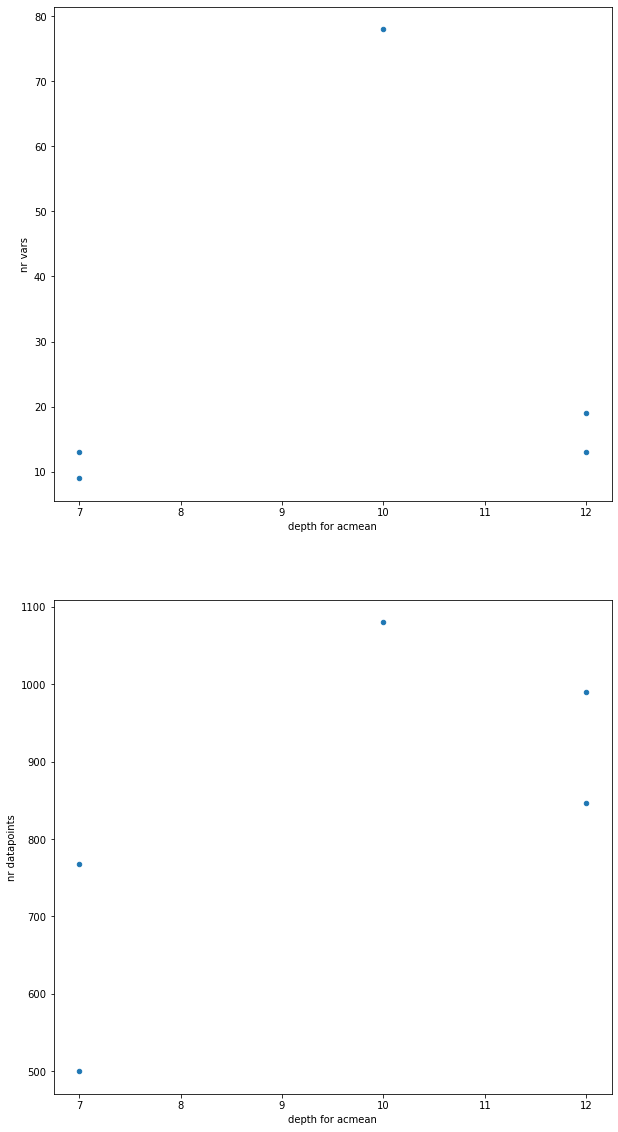

In [87]:
fig, ax = plt.subplots(nrows=2,  figsize=(10, 20))
best_df.plot(kind = "scatter", x = "depth for acmean", y = "nr vars", ax = ax[0])

best_df.plot(kind = "scatter", x = "depth for acmean", y = "nr datapoints", ax = ax[1])

In [97]:
#make a best df but with all ll columns of each dataset
useful_cols = ["acmean", "llmean"]
lls = ["ll"+str(i) for i in range(10)]
useful_cols.extend(lls)
augmented_best_df = get_best(best_dict, useful_cols)
augmented_best_df = add_info(augmented_best_df)
augmented_best_df

,dataset,depth for acmean,depth for llmean,depth for ll0,depth for ll1,depth for ll2,depth for ll3,depth for ll4,depth for ll5,depth for ll6,depth for ll7,depth for ll8,depth for ll9,target classes,nr vars,nr datapoints,full size,ratio var/data
0,diabetes,7,12,15,10,13,11,8,14,10,12,12,8,2.0,9,768,6912,0.011719
2,dresses,7,3,5,3,4,3,2,11,2,5,15,2,2.0,13,500,6500,0.026000
3,mice,10,15,10,12,11,15,13,12,15,15,14,12,8.0,78,1080,84240,0.072222
4,vehicle,12,15,14,13,13,13,15,11,15,12,13,13,4.0,19,846,16074,0.022459
5,vowel,12,12,12,12,12,12,12,11,12,12,12,11,11.0,13,990,12870,0.013131


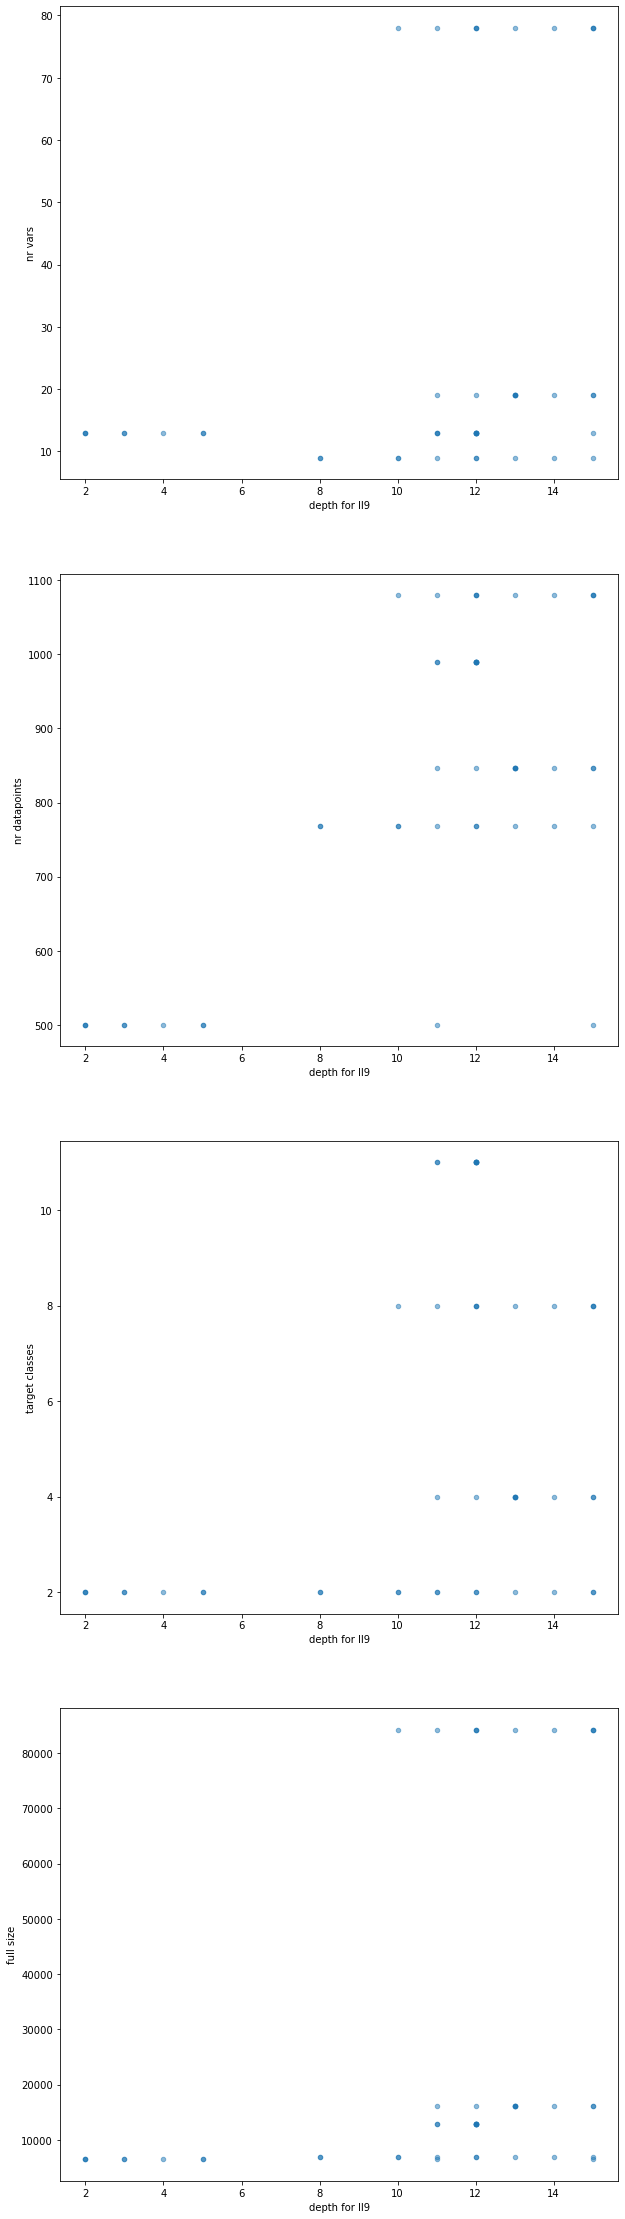

In [108]:
fig, ax = plt.subplots(nrows=4,  figsize=(10, 40))
for col in lls:
    augmented_best_df.plot(kind = "scatter", x = f"depth for {col}", y = "nr vars", ax = ax[0], alpha = 0.5)
   
    augmented_best_df.plot(kind = "scatter", x = f"depth for {col}", y = "nr datapoints", ax = ax[1], alpha = 0.5)
    augmented_best_df.plot(kind = "scatter", x = f"depth for {col}", y = "target classes", ax = ax[2], alpha = 0.5)
    augmented_best_df.plot(kind = "scatter", x = f"depth for {col}", y = "full size", ax = ax[3], alpha = 0.5)
#ax

In [99]:
#the same but for accuracy:
useful_cols2 = ["acmean", "llmean"]
acs = ["ac"+str(i) for i in range(10)]
useful_cols2.extend(acs)
augmented_best_df2 = get_best(best_dict, useful_cols2)
augmented_best_df2 = add_info(augmented_best_df2)
augmented_best_df2

,dataset,depth for acmean,depth for llmean,depth for ac0,depth for ac1,depth for ac2,depth for ac3,depth for ac4,depth for ac5,depth for ac6,depth for ac7,depth for ac8,depth for ac9,target classes,nr vars,nr datapoints,full size,ratio var/data
0,diabetes,7,12,11,7,12,5,13,6,2,6,15,7,2.0,9,768,6912,0.011719
2,dresses,7,3,12,5,4,7,10,11,3,1,7,7,2.0,13,500,6500,0.026000
3,mice,10,15,13,8,13,7,10,7,11,10,7,10,8.0,78,1080,84240,0.072222
4,vehicle,12,15,9,15,10,9,6,8,6,11,12,9,4.0,19,846,16074,0.022459
5,vowel,12,12,7,12,12,10,11,10,10,11,9,10,11.0,13,990,12870,0.013131


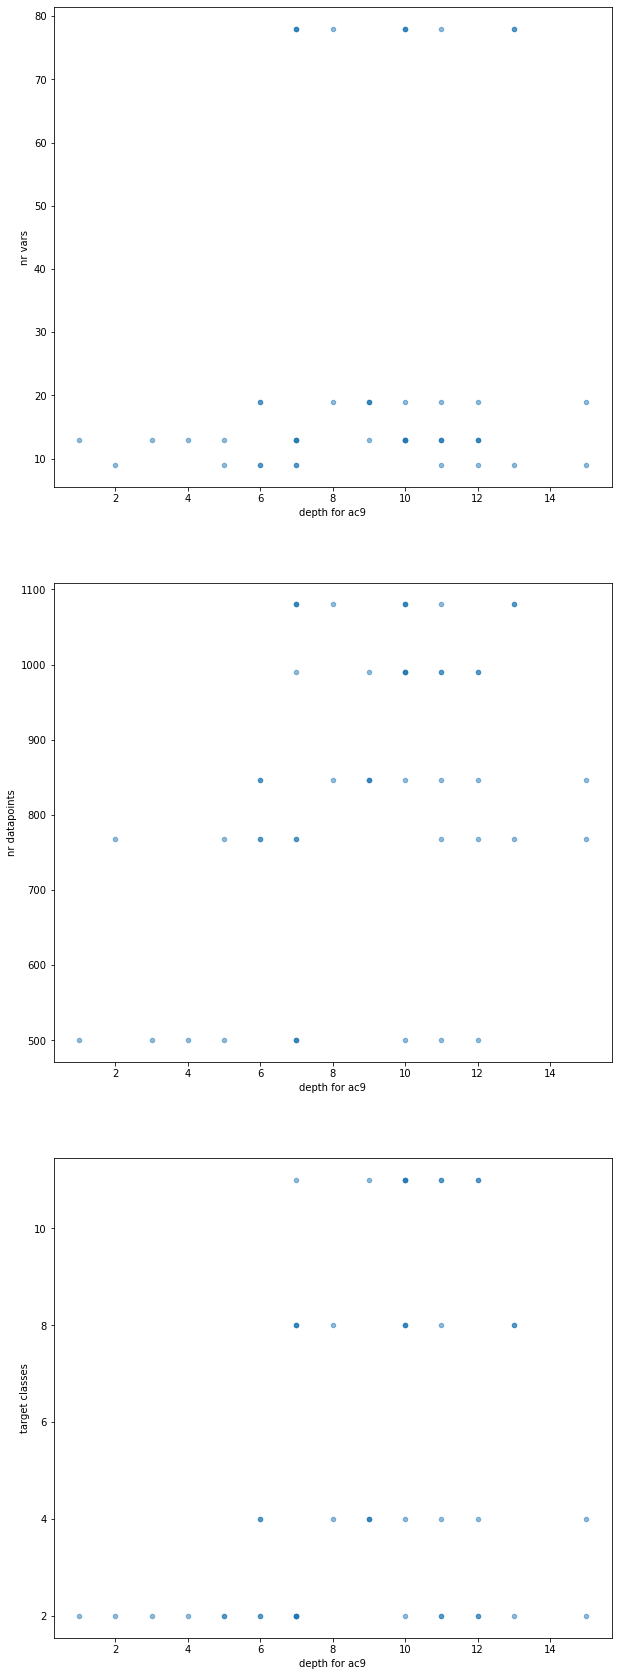

In [100]:
fig, ax = plt.subplots(nrows=3,  figsize=(10, 30))
for col in acs:
    augmented_best_df2.plot(kind = "scatter", x = f"depth for {col}", y = "nr vars", ax = ax[0], alpha = 0.5)
   
    augmented_best_df2.plot(kind = "scatter", x = f"depth for {col}", y = "nr datapoints", ax = ax[1], alpha = 0.5)
    augmented_best_df2.plot(kind = "scatter", x = f"depth for {col}", y = "target classes", ax = ax[2], alpha = 0.5)

In [104]:
#lets do a regression
def get_best2(data_dict, cols):
    best_list = []
    for key in data_dict:
        df = data_dict[key]
        
        for col in cols:
            local_list = [key]
            row = df[df["columns optimized"] == col]
            depth = row.loc[row.index[0],"depth"]
            local_list.append(depth)
            local_list.append(row.loc[row.index[0],"columns optimized"])
            best_list.append(local_list)
    df_cols = ["dataset", "depth", "column"]

    best_df = pd.DataFrame(best_list, columns = df_cols)
    #dna was a bad experiment so is yeeted
    best_df = best_df[best_df['dataset'] != "dna"]

    return(best_df)
useful_cols = [ "llmean"]
useful_cols.extend(lls)
best2_df = get_best2(best_dict, useful_cols)
best2_df = add_info(best2_df)
best2_df

,dataset,depth,column,target classes,nr vars,nr datapoints,full size,ratio var/data
0,diabetes,12,llmean,2.0,9,768,6912,0.011719
1,diabetes,15,ll0,2.0,9,768,6912,0.011719
2,diabetes,10,ll1,2.0,9,768,6912,0.011719
3,diabetes,13,ll2,2.0,9,768,6912,0.011719
4,diabetes,11,ll3,2.0,9,768,6912,0.011719
5,diabetes,8,ll4,2.0,9,768,6912,0.011719
6,diabetes,14,ll5,2.0,9,768,6912,0.011719
7,diabetes,10,ll6,2.0,9,768,6912,0.011719
8,diabetes,12,ll7,2.0,9,768,6912,0.011719
9,diabetes,12,ll8,2.0,9,768,6912,0.011719


In [102]:
from sklearn.linear_model import LinearRegression

In [113]:
#selecting data:
X = best2_df[["target classes", "nr vars", "nr datapoints", "full size"]]
y = best2_df[["depth"]]

#normalizing everything (optional, easier to interpret relative scale of effects but less useful for further prediction)
X = (X-X.mean())/X.std()
X
#doing the regression
reg = LinearRegression()
reg.fit(X,y)

reg.coef_, reg.intercept_

(array([[ -2.38794725,  17.62212885,   7.0380104 , -19.94242277]]),
 array([10.92727273]))

In [117]:
best2_df.corr()

,depth,target classes,nr vars,nr datapoints,full size,ratio var/data
depth,1.000000,0.383616,0.311272,0.697316,0.350544,0.174745
target classes,0.383616,1.000000,0.376949,0.801686,0.422622,0.257201
nr vars,0.311272,0.376949,1.000000,0.619437,0.997358,0.980254
nr datapoints,0.697316,0.801686,0.619437,1.000000,0.670400,0.458779
full size,0.350544,0.422622,0.997358,0.670400,1.000000,0.963764
ratio var/data,0.174745,0.257201,0.980254,0.458779,0.963764,1.000000


In [106]:
#again, also accuracy:
useful_cols = [ "acmean"]
useful_cols.extend(acs)
best2_df_ac = get_best2(best_dict, useful_cols)
best2_df_ac = add_info(best2_df_ac)
best2_df_ac

,dataset,depth,column,target classes,nr vars,nr datapoints,full size,ratio var/data
0,diabetes,7,acmean,2.0,9,768,6912,0.011719
1,diabetes,11,ac0,2.0,9,768,6912,0.011719
2,diabetes,7,ac1,2.0,9,768,6912,0.011719
3,diabetes,12,ac2,2.0,9,768,6912,0.011719
4,diabetes,5,ac3,2.0,9,768,6912,0.011719
5,diabetes,13,ac4,2.0,9,768,6912,0.011719
6,diabetes,6,ac5,2.0,9,768,6912,0.011719
7,diabetes,2,ac6,2.0,9,768,6912,0.011719
8,diabetes,6,ac7,2.0,9,768,6912,0.011719
9,diabetes,15,ac8,2.0,9,768,6912,0.011719


In [111]:
#selecting data:
X = best2_df_ac[["target classes", "nr vars", "nr datapoints"]]#, "full size"]]
y = best2_df_ac[["depth"]]

#normalizing everything (optional, easier to interpret relative scale of effects but less useful for further prediction)
X = (X-X.mean())/X.std()
#X
#doing the regression
reg = LinearRegression()
reg.fit(X,y)

reg.coef_, reg.intercept_

(array([[ 0.07960056, -0.52606215,  1.45624115]]), array([8.94545455]))

In [118]:
#find correlation ll, ac:
best_df.corr()

,depth for acmean,depth for llmean,target classes,nr vars,nr datapoints,full size,ratio var/data
depth for acmean,1.000000,0.642530,0.721662,0.174083,0.685197,0.204966,0.065073
depth for llmean,0.642530,1.000000,0.436349,0.441798,0.857366,0.486588,0.280318
target classes,0.721662,0.436349,1.000000,0.376949,0.801686,0.422622,0.257201
nr vars,0.174083,0.441798,0.376949,1.000000,0.619437,0.997358,0.980254
nr datapoints,0.685197,0.857366,0.801686,0.619437,1.000000,0.670400,0.458779
full size,0.204966,0.486588,0.422622,0.997358,0.670400,1.000000,0.963764
ratio var/data,0.065073,0.280318,0.257201,0.980254,0.458779,0.963764,1.000000
